---
# ИМПОРТ БИБЛИОТЕК И КОНФИГУРАЦИЯ

In [1]:
# ====================================================================================
# ИМПОРТ БИБЛИОТЕК
# ====================================================================================

import os
import warnings
from datetime import datetime
from pathlib import Path
import time
import gc

# Данные
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pointbiserialr

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# ML (для импутации)
from sklearn.impute import SimpleImputer

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

ПОДГОТОВКА ДАННЫХ И EDA (ПОЛНЫЙ PREPROCESSING)
✓ Библиотеки импортированы
  Pandas: 2.2.2
  NumPy: 1.26.4
  Дата запуска: 2025-11-17 14:41:45


In [2]:
# ====================================================================================
# КОНФИГУРАЦИЯ
# ====================================================================================

class Config:
    """Централизованная конфигурация"""
    
    # ВОСПРОИЗВОДИМОСТЬ
    RANDOM_SEED = 42
    
    # ПУТИ
    DATA_DIR = Path("data")
    OUTPUT_DIR = Path("output")
    FIGURES_DIR = Path("figures")
    
    # ФАЙЛЫ
    TRAIN_FILE = "churn_train_ul.parquet"
    
    # КОЛОНКИ
    ID_COLUMNS = ['cli_code', 'client_id', 'observation_point']
    TARGET_COLUMN = 'target_churn_3m'
    SEGMENT_COLUMN = 'segment_group'
    DATE_COLUMN = 'observation_point'
    CATEGORICAL_FEATURES = ['segment_group', 'obs_month', 'obs_quarter']
    
    # СЕГМЕНТЫ (ДВЕ МОДЕЛИ)
    SEGMENT_1_NAME = "Small Business"
    SEGMENT_1_VALUES = ['SMALL_BUSINESS']
    
    SEGMENT_2_NAME = "Middle + Large Business"
    SEGMENT_2_VALUES = ['MIDDLE_BUSINESS', 'LARGE_BUSINESS']
    
    # ВРЕМЕННОЕ РАЗБИЕНИЕ
    TRAIN_SIZE = 0.70
    VAL_SIZE = 0.15
    TEST_SIZE = 0.15
    
    # PREPROCESSING (как в исходном файле)
    REMOVE_GAPS = True  # Gap detection
    HANDLE_OUTLIERS = True  # IQR clipping
    REMOVE_HIGH_CORRELATIONS = True  # Удаление коррелирующих признаков
    CORRELATION_THRESHOLD = 0.85  # Порог корреляции между признаками
    OUTLIER_IQR_MULTIPLIER = 1.5  # Множитель для IQR
    
    # CORRELATION ANALYSIS С TARGET
    CORRELATION_P_VALUE_THRESHOLD = 0.05
    DATA_LEAKAGE_THRESHOLD = 0.9
    TOP_N_CORRELATIONS = 20
    TOP_N_VISUALIZATION = 30
    
    @classmethod
    def create_directories(cls):
        for dir_path in [cls.OUTPUT_DIR, cls.FIGURES_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)
    
    @classmethod
    def get_train_path(cls):
        return cls.DATA_DIR / cls.TRAIN_FILE

config = Config()
config.create_directories()
np.random.seed(config.RANDOM_SEED)

print("\n✓ Конфигурация инициализирована")
print(f"  Random seed: {config.RANDOM_SEED}")
print(f"  Сегмент 1: {config.SEGMENT_1_NAME} {config.SEGMENT_1_VALUES}")
print(f"  Сегмент 2: {config.SEGMENT_2_NAME} {config.SEGMENT_2_VALUES}")
print(f"  Split: {config.TRAIN_SIZE}/{config.VAL_SIZE}/{config.TEST_SIZE}")
print(f"\nPREPROCESSING FLAGS:")
print(f"  Gap detection: {config.REMOVE_GAPS}")
print(f"  Outliers handling: {config.HANDLE_OUTLIERS} (IQR × {config.OUTLIER_IQR_MULTIPLIER})")
print(f"  High correlations removal: {config.REMOVE_HIGH_CORRELATIONS} (threshold={config.CORRELATION_THRESHOLD})")


✓ Конфигурация инициализирована
  Random seed: 42
  Сегмент 1: Small Business ['SMALL_BUSINESS']
  Сегмент 2: Middle + Large Business ['MIDDLE_BUSINESS', 'LARGE_BUSINESS']
  Split: 0.7/0.15/0.15

PREPROCESSING FLAGS:
  Gap detection: True
  Outliers handling: True (IQR × 1.5)
  High correlations removal: True (threshold=0.85)


---
# ЗАГРУЗКА ДАННЫХ

In [3]:
# ====================================================================================
# ЗАГРУЗКА ДАННЫХ
# ====================================================================================

train_path = config.get_train_path()

print("\n" + "="*80)
print("ЗАГРУЗКА ДАННЫХ")
print("="*80)
print(f"Файл: {train_path}")

if not train_path.exists():
    raise FileNotFoundError(
        f"Файл не найден: {train_path}\n"
        f"Убедитесь, что файл {config.TRAIN_FILE} находится в папке data/"
    )

file_size = train_path.stat().st_size / (1024**2)
print(f"Размер файла: {file_size:.2f} MB")

start = time.time()
df_full = pd.read_parquet(train_path)
load_time = time.time() - start

memory = df_full.memory_usage(deep=True).sum() / (1024**2)

print(f"\n✓ Загружено за {load_time:.2f} сек")
print(f"  Размер: {df_full.shape}")
print(f"  Память: {memory:.2f} MB")
print(f"  Строк: {len(df_full):,}")
print(f"  Колонок: {df_full.shape[1]}")
print("="*80)


ЗАГРУЗКА ДАННЫХ
Файл: data\churn_train_ul.parquet
Размер файла: 747.39 MB

✓ Загружено за 1.58 сек
  Размер: (3243871, 195)
  Память: 2094.37 MB
  Строк: 3,243,871
  Колонок: 195


---
# EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
# ====================================================================================
# БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ
# ====================================================================================

print("\n" + "="*80)
print("БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ")
print("="*80)

print(f"\n1. РАЗМЕР ДАННЫХ:")
print(f"   Строк: {len(df_full):,}")
print(f"   Колонок: {df_full.shape[1]}")
print(f"   Память: {df_full.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

print(f"\n2. ТИПЫ ДАННЫХ:")
dtype_counts = df_full.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   {dtype}: {count}")


БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ

1. РАЗМЕР ДАННЫХ:
   Строк: 3,243,871
   Колонок: 195
   Память: 2094.37 MB

2. ТИПЫ ДАННЫХ:
   float32: 125
   int8: 62
   int64: 5
   object: 1
   category: 1
   int16: 1

3. ПЕРВЫЕ 5 СТРОК:
   cli_code  client_id        observation_point  target_churn_3m  \
0      8996       1056  2023-06-30 00:00:00.000                0   
1     48912      18183  2023-06-30 00:00:00.000                0   
2     53664    1764421  2024-07-31 00:00:00.000                0   
3     60486      22148  2024-10-31 00:00:00.000                0   
4     66909      24954  2023-11-30 00:00:00.000                0   

     segment_group  obs_months_count  avg_activity_6m  active_months_6m  \
0   SMALL_BUSINESS                 6           0.0000                 0   
1   SMALL_BUSINESS                 6           1.0000                 6   
2   SMALL_BUSINESS                 6           1.0000                 6   
3   SMALL_BUSINESS                 6           0.0000               

In [5]:
# ====================================================================================
# АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
# ====================================================================================

print("\n" + "="*80)
print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (TARGET)")
print("="*80)

# Общий churn rate
churn_rate = df_full[config.TARGET_COLUMN].mean()
n_churned = df_full[config.TARGET_COLUMN].sum()
n_total = len(df_full)
ratio = (1-churn_rate)/churn_rate

print(f"\n1. ОБЩИЙ CHURN RATE:")
print(f"   Churn rate: {churn_rate:.4f} ({churn_rate*100:.2f}%)")
print(f"   Churned: {n_churned:,}")
print(f"   Not churned: {n_total - n_churned:,}")
print(f"   Class ratio: 1:{ratio:.1f}")

# Churn rate по сегментам
print(f"\n2. CHURN RATE ПО СЕГМЕНТАМ:")
for segment in df_full[config.SEGMENT_COLUMN].unique():
    segment_df = df_full[df_full[config.SEGMENT_COLUMN] == segment]
    seg_churn = segment_df[config.TARGET_COLUMN].mean()
    seg_count = len(segment_df)
    seg_pct = seg_count / len(df_full) * 100
    print(f"   {segment}:")
    print(f"     Размер: {seg_count:,} ({seg_pct:.1f}%)")
    print(f"     Churn rate: {seg_churn:.4f} ({seg_churn*100:.2f}%)")

print("="*80)


АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (TARGET)

1. ОБЩИЙ CHURN RATE:
   Churn rate: 0.0150 (1.50%)
   Churned: 48,708
   Not churned: 3,195,163
   Class ratio: 1:65.6

2. CHURN RATE ПО СЕГМЕНТАМ:
   SMALL_BUSINESS:
     Размер: 3,032,498 (93.5%)
     Churn rate: 0.0156 (1.56%)
   MIDDLE_BUSINESS:
     Размер: 189,911 (5.9%)
     Churn rate: 0.0059 (0.59%)
   LARGE_BUSINESS:
     Размер: 21,462 (0.7%)
     Churn rate: 0.0068 (0.68%)


In [6]:
# ====================================================================================
# АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
# ====================================================================================

print("\n" + "="*80)
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("="*80)

missing = df_full.isnull().sum()
missing_df = pd.DataFrame({
    'Missing': missing[missing > 0],
    'Percent': (missing[missing > 0] / len(df_full) * 100).round(2)
}).sort_values('Missing', ascending=False)

print(f"\nКолонок с пропусками: {len(missing_df)}")

if len(missing_df) > 0:
    print(f"\nТоп-20 колонок с наибольшим количеством пропусков:")
    print(missing_df.head(20))
else:
    print("\n✓ Пропущенных значений не обнаружено")

print("="*80)


АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Колонок с пропусками: 0

✓ Пропущенных значений не обнаружено


In [7]:
# ====================================================================================
# АНАЛИЗ КОНСТАНТНЫХ КОЛОНОК
# ====================================================================================

print("\n" + "="*80)
print("АНАЛИЗ КОНСТАНТНЫХ КОЛОНОК")
print("="*80)

constant_cols = []
for col in df_full.columns:
    if df_full[col].nunique(dropna=False) == 1:
        constant_cols.append(col)

print(f"\nКонстантных колонок: {len(constant_cols)}")

if constant_cols:
    print(f"\nСписок константных колонок:")
    for col in constant_cols:
        print(f"  - {col} (значение: {df_full[col].iloc[0]})")
else:
    print("\n✓ Константных колонок не обнаружено")

print("="*80)


АНАЛИЗ КОНСТАНТНЫХ КОЛОНОК

Константных колонок: 9

Список константных колонок:
  - obs_months_count (значение: 6)
  - total_lending_ebrd_pl_6m (значение: 0)
  - total_bonds_pl_6m (значение: 0)
  - avg_deposits_liabilities_6m (значение: 0)
  - avg_guarantees_liabilities_6m (значение: 0)
  - avg_cards_liabilities_6m (значение: 0)
  - profitable_months_6m (значение: 6)
  - mostly_profitable (значение: 1)
  - negative_margin (значение: 0)


In [8]:
# ====================================================================================
# АНАЛИЗ ВРЕМЕННОГО РАСПРЕДЕЛЕНИЯ
# ====================================================================================

print("\n" + "="*80)
print("АНАЛИЗ ВРЕМЕННОГО РАСПРЕДЕЛЕНИЯ")
print("="*80)

# Конвертация даты
df_full[config.DATE_COLUMN] = pd.to_datetime(df_full[config.DATE_COLUMN])

print(f"\n1. ВРЕМЕННОЙ ПЕРИОД:")
print(f"   Начало: {df_full[config.DATE_COLUMN].min().date()}")
print(f"   Конец: {df_full[config.DATE_COLUMN].max().date()}")
print(f"   Уникальных дат: {df_full[config.DATE_COLUMN].nunique()}")

print(f"\n2. КЛИЕНТЫ:")
print(f"   Уникальных cli_code: {df_full['cli_code'].nunique():,}")
print(f"   Уникальных client_id: {df_full['client_id'].nunique():,}")

# Распределение по датам
print(f"\n3. РАСПРЕДЕЛЕНИЕ ЗАПИСЕЙ ПО ДАТАМ:")
date_dist = df_full.groupby(config.DATE_COLUMN).size()
print(f"   Среднее записей на дату: {date_dist.mean():.0f}")
print(f"   Минимум: {date_dist.min():,}")
print(f"   Максимум: {date_dist.max():,}")

print("="*80)


АНАЛИЗ ВРЕМЕННОГО РАСПРЕДЕЛЕНИЯ

1. ВРЕМЕННОЙ ПЕРИОД:
   Начало: 2023-06-30
   Конец: 2025-06-30
   Уникальных дат: 25

2. КЛИЕНТЫ:
   Уникальных cli_code: 201,019
   Уникальных client_id: 201,019

3. РАСПРЕДЕЛЕНИЕ ЗАПИСЕЙ ПО ДАТАМ:
   Среднее записей на дату: 129755
   Минимум: 123,669
   Максимум: 137,171


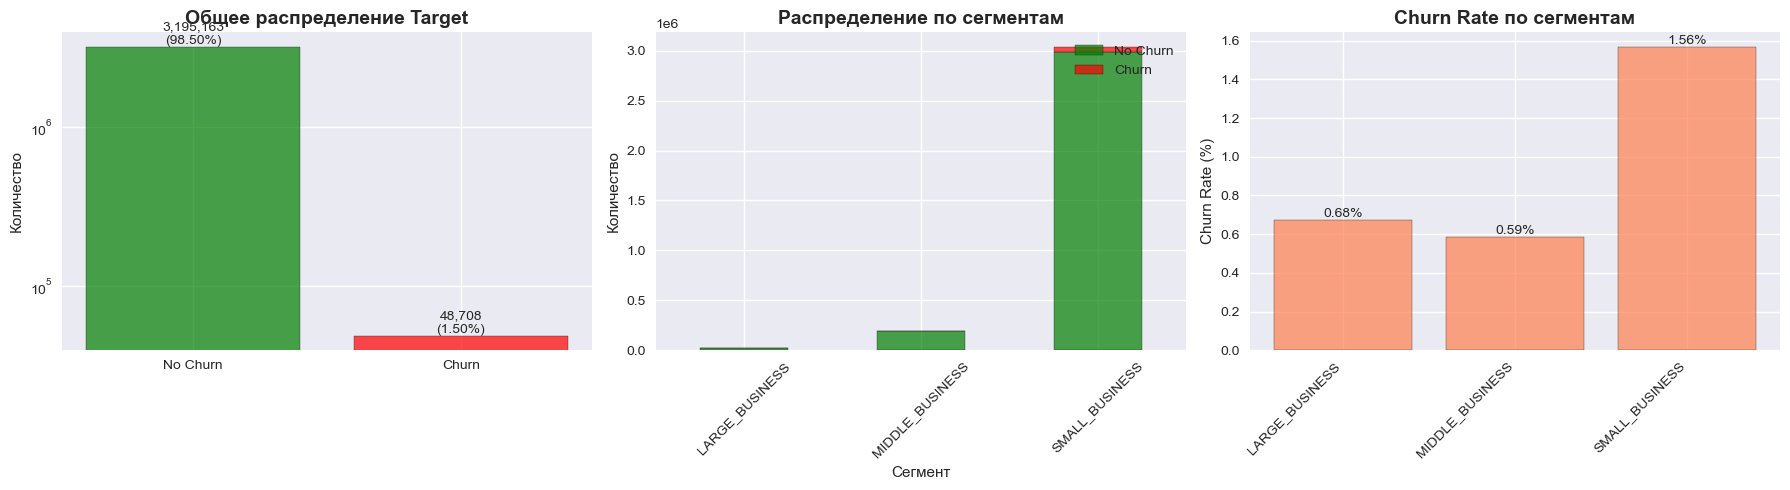

✓ Сохранено: figures/eda_target_distribution.png


In [9]:
# ====================================================================================
# ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ TARGET
# ====================================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Общее распределение
target_dist = df_full[config.TARGET_COLUMN].value_counts()
axes[0].bar(['No Churn', 'Churn'], [target_dist[0], target_dist[1]],
           color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_title('Общее распределение Target', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Количество')
axes[0].set_yscale('log')
for i, v in enumerate([target_dist[0], target_dist[1]]):
    axes[0].text(i, v, f'{v:,}\n({v/len(df_full)*100:.2f}%)',
                ha='center', va='bottom', fontsize=10)

# 2. По сегментам (stacked)
segment_churn = df_full.groupby([config.SEGMENT_COLUMN, 
                                  config.TARGET_COLUMN]).size().unstack(fill_value=0)
segment_churn.plot(kind='bar', stacked=True, ax=axes[1],
                  color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_title('Распределение по сегментам', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Сегмент')
axes[1].set_ylabel('Количество')
axes[1].legend(['No Churn', 'Churn'], loc='upper right')
axes[1].tick_params(axis='x', rotation=45)

# 3. Churn rate по сегментам
churn_rates = df_full.groupby(config.SEGMENT_COLUMN)[config.TARGET_COLUMN].mean() * 100
axes[2].bar(range(len(churn_rates)), churn_rates.values,
           color='coral', alpha=0.7, edgecolor='black')
axes[2].set_xticks(range(len(churn_rates)))
axes[2].set_xticklabels(churn_rates.index, rotation=45, ha='right')
axes[2].set_title('Churn Rate по сегментам', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Churn Rate (%)')
for i, v in enumerate(churn_rates.values):
    axes[2].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'eda_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Сохранено: figures/eda_target_distribution.png")

## ВРЕМЕННОЕ РАЗБИЕНИЕ (TEMPORAL SPLIT)

Разбиение данных по времени для предотвращения data leakage:  
- **Train:** 70% первых по времени
- **Validation:** 15%
- **Test (OOT):** 15% последних

In [10]:
# ====================================================================================
# TEMPORAL SPLIT
# ====================================================================================

print("\n" + "="*80)
print("ВРЕМЕННОЕ РАЗБИЕНИЕ (TEMPORAL SPLIT)")
print("="*80)

# Сортировка по времени
df_sorted = df_full.sort_values(config.DATE_COLUMN).reset_index(drop=True)
unique_dates = sorted(df_sorted[config.DATE_COLUMN].unique())
n_dates = len(unique_dates)

print(f"\nУникальных дат: {n_dates}")
print(f"Период: {unique_dates[0].date()} - {unique_dates[-1].date()}")

# Cutoff indices
train_cutoff = int(n_dates * config.TRAIN_SIZE)
val_cutoff = int(n_dates * (config.TRAIN_SIZE + config.VAL_SIZE))

train_end = unique_dates[train_cutoff - 1]
val_end = unique_dates[val_cutoff - 1]

print(f"\nCutoff даты:")
print(f"  Train: до {train_end.date()} ({train_cutoff} дат)")
print(f"  Val: {unique_dates[train_cutoff].date()} - {val_end.date()} ({val_cutoff - train_cutoff} дат)")
print(f"  Test (OOT): {unique_dates[val_cutoff].date()}+ ({n_dates - val_cutoff} дат)")

# Создание split
train_df = df_sorted[df_sorted[config.DATE_COLUMN] <= train_end].copy()
val_df = df_sorted[(df_sorted[config.DATE_COLUMN] > train_end) & 
                   (df_sorted[config.DATE_COLUMN] <= val_end)].copy()
test_df = df_sorted[df_sorted[config.DATE_COLUMN] > val_end].copy()

# Статистика по split
print(f"\n{'='*80}")
print("СТАТИСТИКА ПО SPLIT")
print(f"{'='*80}")

for name, df in [('TRAIN', train_df), ('VALIDATION', val_df), ('TEST (OOT)', test_df)]:
    churn_r = df[config.TARGET_COLUMN].mean()
    print(f"\n{name}:")
    print(f"  Записей: {len(df):,}")
    print(f"  Клиентов (cli_code): {df['cli_code'].nunique():,}")
    print(f"  Период: {df[config.DATE_COLUMN].min().date()} - {df[config.DATE_COLUMN].max().date()}")
    print(f"  Churn rate: {churn_r:.4f} ({churn_r*100:.2f}%)")
    print(f"  Процент от общего: {len(df)/len(df_full)*100:.2f}%")

# Проверка data leakage
assert train_df[config.DATE_COLUMN].max() < val_df[config.DATE_COLUMN].min(), "Data leakage detected!"
assert val_df[config.DATE_COLUMN].max() < test_df[config.DATE_COLUMN].min(), "Data leakage detected!"
print(f"\n✓ Temporal ordering verified - NO DATA LEAKAGE")

print("="*80)


ВРЕМЕННОЕ РАЗБИЕНИЕ (TEMPORAL SPLIT)

Уникальных дат: 25
Период: 2023-06-30 - 2025-06-30

Cutoff даты:
  Train: до 2024-10-31 (17 дат)
  Val: 2024-11-30 - 2025-02-28 (4 дат)
  Test (OOT): 2025-03-31+ (4 дат)

СТАТИСТИКА ПО SPLIT

TRAIN:
  Записей: 2,162,862
  Клиентов (cli_code): 173,448
  Период: 2023-06-30 - 2024-10-31
  Churn rate: 0.0144 (1.44%)
  Процент от общего: 66.68%

VALIDATION:
  Записей: 535,263
  Клиентов (cli_code): 144,022
  Период: 2024-11-30 - 2025-02-28
  Churn rate: 0.0178 (1.78%)
  Процент от общего: 16.50%

TEST (OOT):
  Записей: 545,746
  Клиентов (cli_code): 146,264
  Период: 2025-03-31 - 2025-06-30
  Churn rate: 0.0145 (1.45%)
  Процент от общего: 16.82%

✓ Temporal ordering verified - NO DATA LEAKAGE


In [11]:
# ====================================================================================
# GAP DETECTION - УДАЛЕНИЕ КЛИЕНТОВ С ПРОБЕЛАМИ
# ====================================================================================

if config.REMOVE_GAPS:
    print("\n" + "="*80)
    print("GAP DETECTION - УДАЛЕНИЕ КЛИЕНТОВ С ПРОБЕЛАМИ")
    print("="*80)

    print("\nАнализ пробелов в train данных...")

    # Chunked processing для экономии памяти
    unique_clients = train_df['cli_code'].unique()
    chunk_size = 10000
    clients_with_gaps_list = []

    for i in range(0, len(unique_clients), chunk_size):
        chunk_clients = unique_clients[i:i+chunk_size]
        chunk = train_df[train_df['cli_code'].isin(chunk_clients)].copy()
        chunk = chunk.sort_values(['cli_code', config.DATE_COLUMN])

        # Конвертируем даты в месячные номера
        chunk['month_num'] = chunk[config.DATE_COLUMN].dt.to_period('M').apply(lambda x: x.ordinal)
        chunk['month_diff'] = chunk.groupby('cli_code')['month_num'].diff()

        # Анализ пробелов
        gaps = chunk.groupby('cli_code')['month_diff'].agg([
            ('max_gap', 'max'),
            ('total_gaps', lambda x: (x > 1).sum())
        ]).reset_index()

        chunk_gaps = gaps[gaps['max_gap'] > 1]
        clients_with_gaps_list.append(chunk_gaps)

        if (i // chunk_size + 1) % 10 == 0:
            gc.collect()
            print(f"  Обработано {i+chunk_size:,}/{len(unique_clients):,} клиентов")

    clients_with_gaps = pd.concat(clients_with_gaps_list, ignore_index=True)

    gap_pct = len(clients_with_gaps) / len(unique_clients) * 100
    print(f"\nКлиентов с пробелами: {len(clients_with_gaps):,} ({gap_pct:.2f}%)")

    if len(clients_with_gaps) > 0:
        bad_clients = set(clients_with_gaps['cli_code'])

        train_before = len(train_df)
        val_before = len(val_df)
        test_before = len(test_df)
        
        train_df = train_df[~train_df['cli_code'].isin(bad_clients)].copy()
        val_df = val_df[~val_df['cli_code'].isin(bad_clients)].copy()
        test_df = test_df[~test_df['cli_code'].isin(bad_clients)].copy()

        print(f"\nУдалено:")
        print(f"  Train: {train_before:,} {len(train_df):,} (-{train_before - len(train_df):,})")
        print(f"  Val: {val_before:,} {len(val_df):,} (-{val_before - len(val_df):,})")
        print(f"  Test: {test_before:,} {len(test_df):,} (-{test_before - len(test_df):,})")

        del clients_with_gaps, bad_clients
        gc.collect()
    else:
        print("\n✓ Клиентов с пробелами не обнаружено")

    print("="*80)
else:
    print("\n Gap detection отключен (config.REMOVE_GAPS=False)")


GAP DETECTION - УДАЛЕНИЕ КЛИЕНТОВ С ПРОБЕЛАМИ

Анализ пробелов в train данных...
  Обработано 100,000/173,448 клиентов

Клиентов с пробелами: 1,131 (0.65%)

Удалено:
  Train: 2,162,862 → 2,153,407 (-9,455)
  Val: 535,263 → 531,880 (-3,383)
  Test: 545,746 → 542,902 (-2,844)


In [12]:
# ====================================================================================
# PREPROCESSING PIPELINE
# ====================================================================================

class PreprocessingPipeline:
    """Полный preprocessing pipeline из исходного файла"""

    def __init__(self, config):
        self.config = config
        self.fitted_columns = None
        self.final_features = None
        self.constant_cols = []
        self.outlier_bounds = {}
        self.numeric_imputer = None
        self.categorical_imputer = None
        self.numeric_cols_for_imputation = []
        self.categorical_cols_for_imputation = []
        self.features_to_drop_corr = []

    def fit_transform(self, train_df):
        """Fit and transform training data"""
        print("\n" + "="*80)
        print("PREPROCESSING: FIT_TRANSFORM ON TRAIN")
        print("="*80)

        df = train_df.copy()

        # Store columns
        self.fitted_columns = [c for c in df.columns
                              if c not in config.ID_COLUMNS + [config.TARGET_COLUMN]]

        # 1. Remove constants
        df = self._remove_constants(df, fit=True)

        # 2. Handle outliers (IQR clipping)
        df = self._handle_outliers(df, fit=True)

        # 3. Handle missing
        df = self._handle_missing(df, fit=True)

        # 4. Remove high correlations
        df = self._remove_correlations(df, fit=True)

        # Final features
        self.final_features = [c for c in df.columns
                              if c not in config.ID_COLUMNS + [config.TARGET_COLUMN]]

        print(f"\n✓ Preprocessing complete")
        print(f"  Final features: {len(self.final_features)}")

        return df

    def transform(self, df, dataset_name='test'):
        """Transform new data"""
        print(f"\nPreprocessing: {dataset_name}")

        df = df.copy()

        df = self._remove_constants(df, fit=False)
        df = self._handle_outliers(df, fit=False)
        df = self._handle_missing(df, fit=False)
        df = self._remove_correlations(df, fit=False)
        df = self._align_columns(df, dataset_name)

        print(f"  ✓ {dataset_name}: {df.shape}")

        return df

    def _remove_constants(self, df, fit):
        if fit:
            print("\n1. Removing constant columns...")
            for col in df.columns:
                if col in config.ID_COLUMNS + [config.TARGET_COLUMN]:
                    continue
                if df[col].nunique(dropna=False) == 1:
                    self.constant_cols.append(col)

            if self.constant_cols:
                df = df.drop(columns=self.constant_cols)
                print(f"   Removed: {len(self.constant_cols)}")
            else:
                print(f"   ✓ No constant columns found")
        return df

    def _handle_outliers(self, df, fit):
        """IQR-based outlier clipping для финансовых признаков"""
        if not config.HANDLE_OUTLIERS:
            return df

        if fit:
            print("\n2. Handling outliers (IQR clipping)...")
            # Ключевые слова для финансовых признаков
            keywords = ['profit', 'income', 'expense', 'margin', 'provision',
                       'balance', 'assets', 'liabilities', 'revenue', 'cost']
            
            cols = [c for c in df.columns
                   if any(kw in c.lower() for kw in keywords)
                   and c not in config.ID_COLUMNS + [config.TARGET_COLUMN] + config.CATEGORICAL_FEATURES]

            for col in cols:
                if df[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int16', 'int8']:
                    Q1, Q3 = df[col].quantile([0.25, 0.75])
                    IQR = Q3 - Q1
                    self.outlier_bounds[col] = {
                        'lower': Q1 - config.OUTLIER_IQR_MULTIPLIER * IQR,
                        'upper': Q3 + config.OUTLIER_IQR_MULTIPLIER * IQR
                    }

            for col, bounds in self.outlier_bounds.items():
                df[col] = df[col].clip(lower=bounds['lower'], upper=bounds['upper'])

            print(f"   Clipped: {len(self.outlier_bounds)} columns (IQR × {config.OUTLIER_IQR_MULTIPLIER})")
        else:
            for col, bounds in self.outlier_bounds.items():
                if col in df.columns:
                    df[col] = df[col].clip(lower=bounds['lower'], upper=bounds['upper'])

        return df

    def _handle_missing(self, df, fit):
        if fit:
            print("\n3. Handling missing values...")
            self.numeric_cols_for_imputation = [
                c for c in df.select_dtypes(include=[np.number]).columns
                if c not in config.ID_COLUMNS + [config.TARGET_COLUMN]
            ]
            self.categorical_cols_for_imputation = [
                c for c in config.CATEGORICAL_FEATURES if c in df.columns
            ]

            self.numeric_imputer = SimpleImputer(strategy='median')
            self.categorical_imputer = SimpleImputer(strategy='most_frequent')

            if len(self.numeric_cols_for_imputation) > 0:
                df[self.numeric_cols_for_imputation] = self.numeric_imputer.fit_transform(
                    df[self.numeric_cols_for_imputation]
                )

            if len(self.categorical_cols_for_imputation) > 0:
                df[self.categorical_cols_for_imputation] = self.categorical_imputer.fit_transform(
                    df[self.categorical_cols_for_imputation]
                )

            print(f"   Imputed: {len(self.numeric_cols_for_imputation)} numeric, "
                  f"{len(self.categorical_cols_for_imputation)} categorical")
        else:
            if len(self.numeric_cols_for_imputation) > 0:
                present = [c for c in self.numeric_cols_for_imputation if c in df.columns]
                if present:
                    df[present] = self.numeric_imputer.transform(df[present])

            if len(self.categorical_cols_for_imputation) > 0:
                present = [c for c in self.categorical_cols_for_imputation if c in df.columns]
                if present:
                    df[present] = self.categorical_imputer.transform(df[present])

        return df

    def _remove_correlations(self, df, fit):
        """Удаление высоко коррелирующих признаков"""
        if not config.REMOVE_HIGH_CORRELATIONS:
            return df

        if fit:
            print(f"\n4. Removing high correlations (threshold={config.CORRELATION_THRESHOLD})...")
            numeric = [c for c in df.select_dtypes(include=[np.number]).columns
                      if c not in config.ID_COLUMNS + [config.TARGET_COLUMN] + config.CATEGORICAL_FEATURES]

            if len(numeric) > 1:
                corr = df[numeric].corr().abs()
                upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
                self.features_to_drop_corr = [c for c in upper.columns
                                             if any(upper[c] > config.CORRELATION_THRESHOLD)]

                if self.features_to_drop_corr:
                    df = df.drop(columns=self.features_to_drop_corr)
                    print(f"   Removed: {len(self.features_to_drop_corr)} features")
                else:
                    print(f"   ✓ No highly correlated features found")

        return df

    def _align_columns(self, df, name):
        """Выравнивание колонок с train"""
        preserve = [c for c in config.ID_COLUMNS if c in df.columns]
        if config.TARGET_COLUMN in df.columns:
            preserve.append(config.TARGET_COLUMN)

        current = [c for c in df.columns if c not in preserve]
        missing = [c for c in self.final_features if c not in current]
        extra = [c for c in current if c not in self.final_features]

        if missing:
            for c in missing:
                df[c] = 0

        if extra:
            df = df.drop(columns=extra)

        order = preserve + self.final_features
        df = df[[c for c in order if c in df.columns]]

        return df

print("✓ PreprocessingPipeline класс определен")

✓ PreprocessingPipeline класс определен


In [13]:
# ====================================================================================
# ПРИМЕНЕНИЕ PREPROCESSING
# ====================================================================================

pipeline = PreprocessingPipeline(config)
train_processed = pipeline.fit_transform(train_df)
val_processed = pipeline.transform(val_df, 'validation')
test_processed = pipeline.transform(test_df, 'test (OOT)')

print("\n" + "="*80)
print("PREPROCESSING SUMMARY")
print("="*80)
print(f"\nШаги preprocessing:")
print(f"  1. Константные колонки удалено: {len(pipeline.constant_cols)}")
print(f"  2. Выбросы обработано (IQR clipping): {len(pipeline.outlier_bounds)} колонок")
print(f"  3. Пропуски заполнено:")
print(f"     - Числовых: {len(pipeline.numeric_cols_for_imputation)}")
print(f"     - Категориальных: {len(pipeline.categorical_cols_for_imputation)}")
print(f"  4. Коррелирующих признаков удалено: {len(pipeline.features_to_drop_corr)}")
print(f"\nИтоговое количество признаков: {len(pipeline.final_features)}")
print("="*80)


PREPROCESSING: FIT_TRANSFORM ON TRAIN

1. Removing constant columns...
   Removed: 9

2. Handling outliers (IQR clipping)...
   Clipped: 91 columns (IQR × 1.5)

3. Handling missing values...
   Imputed: 181 numeric, 3 categorical

4. Removing high correlations (threshold=0.85)...
   Removed: 61 features

✓ Preprocessing complete
  Final features: 121

Preprocessing: validation
  ✓ validation: (531880, 125)

Preprocessing: test (OOT)
  ✓ test (OOT): (542902, 125)

PREPROCESSING SUMMARY

Шаги preprocessing:
  1. Константные колонки удалено: 9
  2. Выбросы обработано (IQR clipping): 91 колонок
  3. Пропуски заполнено:
     - Числовых: 181
     - Категориальных: 3
  4. Коррелирующих признаков удалено: 61

Итоговое количество признаков: 121


In [14]:
# ====================================================================================
# РАЗДЕЛЕНИЕ ПО СЕГМЕНТАМ
# ====================================================================================

print("\n" + "="*80)
print("РАЗДЕЛЕНИЕ ПО СЕГМЕНТАМ")
print("="*80)

# SEGMENT 1: Small Business
print(f"\n1. SEGMENT 1: {config.SEGMENT_1_NAME.upper()}")
print("-" * 80)

seg1_train = train_processed[train_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_1_VALUES)].copy()
seg1_val = val_processed[val_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_1_VALUES)].copy()
seg1_test = test_processed[test_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_1_VALUES)].copy()

print(f"Исходные размеры:")
print(f"  Train: {seg1_train.shape}")
print(f"  Val: {seg1_val.shape}")
print(f"  Test: {seg1_test.shape}")

# Удаляем segment_group для seg1 (там одно значение) + ID колонки + временные признаки
print(f"\nУникальных значений segment_group: {seg1_train[config.SEGMENT_COLUMN].nunique()}")
print(f"Значения: {seg1_train[config.SEGMENT_COLUMN].unique()}")

# Временные признаки вызывают высокий PSI (train vs test из разных периодов)
temporal_features = ['obs_year', 'obs_month', 'obs_quarter']
cols_to_drop_seg1 = [config.SEGMENT_COLUMN] + [c for c in config.ID_COLUMNS if c in seg1_train.columns] + temporal_features
seg1_train = seg1_train.drop(columns=[c for c in cols_to_drop_seg1 if c in seg1_train.columns])
seg1_val = seg1_val.drop(columns=[c for c in cols_to_drop_seg1 if c in seg1_val.columns])
seg1_test = seg1_test.drop(columns=[c for c in cols_to_drop_seg1 if c in seg1_test.columns])

print(f"\nИтоговые размеры seg1:")
print(f"  Train: {seg1_train.shape} | Churn: {seg1_train[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Val: {seg1_val.shape} | Churn: {seg1_val[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Test: {seg1_test.shape} | Churn: {seg1_test[config.TARGET_COLUMN].mean()*100:.2f}%")

# SEGMENT 2: Middle + Large Business
print(f"\n\n2. SEGMENT 2: {config.SEGMENT_2_NAME.upper()}")
print("-" * 80)

seg2_train = train_processed[train_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_2_VALUES)].copy()
seg2_val = val_processed[val_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_2_VALUES)].copy()
seg2_test = test_processed[test_processed[config.SEGMENT_COLUMN].isin(config.SEGMENT_2_VALUES)].copy()

print(f"Исходные размеры:")
print(f"  Train: {seg2_train.shape}")
print(f"  Val: {seg2_val.shape}")
print(f"  Test: {seg2_test.shape}")

# Оставляем segment_group для seg2 (там два значения) + удаляем только ID + временные
print(f"\nУникальных значений segment_group: {seg2_train[config.SEGMENT_COLUMN].nunique()}")
print(f"Значения: {seg2_train[config.SEGMENT_COLUMN].unique()}")

cols_to_drop_seg2 = [c for c in config.ID_COLUMNS if c in seg2_train.columns] + temporal_features
seg2_train = seg2_train.drop(columns=[c for c in cols_to_drop_seg2 if c in seg2_train.columns])
seg2_val = seg2_val.drop(columns=[c for c in cols_to_drop_seg2 if c in seg2_val.columns])
seg2_test = seg2_test.drop(columns=[c for c in cols_to_drop_seg2 if c in seg2_test.columns])

# Преобразуем segment_group в числовой формат (Label Encoding)
segment_mapping = {'MIDDLE_BUSINESS': 0, 'LARGE_BUSINESS': 1}
seg2_train[config.SEGMENT_COLUMN] = seg2_train[config.SEGMENT_COLUMN].map(segment_mapping)
seg2_val[config.SEGMENT_COLUMN] = seg2_val[config.SEGMENT_COLUMN].map(segment_mapping)
seg2_test[config.SEGMENT_COLUMN] = seg2_test[config.SEGMENT_COLUMN].map(segment_mapping)
print(f"   MIDDLE_BUSINESS 0, LARGE_BUSINESS 1")

print(f"\nИтоговые размеры seg2:")
print(f"  Train: {seg2_train.shape} | Churn: {seg2_train[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Val: {seg2_val.shape} | Churn: {seg2_val[config.TARGET_COLUMN].mean()*100:.2f}%")
print(f"  Test: {seg2_test.shape} | Churn: {seg2_test[config.TARGET_COLUMN].mean()*100:.2f}%")


РАЗДЕЛЕНИЕ ПО СЕГМЕНТАМ

1. SEGMENT 1: SMALL BUSINESS
--------------------------------------------------------------------------------
Исходные размеры:
  Train: (2024010, 125)
  Val: (493087, 125)
  Test: (500370, 125)

Уникальных значений segment_group: 1
Значения: ['SMALL_BUSINESS']

→ Удаляем segment_group (не информативна) + ID колонки + временные признаки

Итоговые размеры seg1:
  Train: (2024010, 118) | Churn: 1.51%
  Val: (493087, 118) | Churn: 1.86%
  Test: (500370, 118) | Churn: 1.50%


2. SEGMENT 2: MIDDLE + LARGE BUSINESS
--------------------------------------------------------------------------------
Исходные размеры:
  Train: (129397, 125)
  Val: (38793, 125)
  Test: (42532, 125)

Уникальных значений segment_group: 2
Значения: ['MIDDLE_BUSINESS' 'LARGE_BUSINESS']

→ Оставляем segment_group (полезный признак) + удаляем ID колонки + временные признаки

→ Преобразуем segment_group в числовой формат для совместимости с моделями
   MIDDLE_BUSINESS → 0, LARGE_BUSINESS → 1

Ито

In [15]:
# ====================================================================================
# ФУНКЦИИ ДЛЯ CORRELATION ANALYSIS
# ====================================================================================

def calculate_pointbiserial_correlations(df, target_col, p_threshold=0.05):
    # Получаем числовые колонки (кроме target)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_col]
    
    results = []
    target_values = df[target_col].values
    
    print(f"Анализируем {len(numeric_cols)} числовых признаков...")
    
    for col in numeric_cols:
        feature_values = df[col].values
        
        # Пропускаем константные колонки
        if len(np.unique(feature_values)) == 1:
            continue
        
        try:
            # Point-Biserial correlation
            corr, pval = pointbiserialr(target_values, feature_values)
            
            results.append({
                'feature': col,
                'correlation': corr,
                'abs_correlation': abs(corr),
                'p_value': pval,
                'significant': pval < p_threshold
            })
        except Exception as e:
            print(f"  Ошибка для {col}: {e}")
            continue
    
    # Создаем DataFrame
    corr_df = pd.DataFrame(results)
    
    # Сортируем по модулю корреляции
    corr_df = corr_df.sort_values('abs_correlation', ascending=False).reset_index(drop=True)
    
    return corr_df


def plot_top_correlations(corr_df, segment_name, top_n=30, save_path=None):
    top_corr = corr_df.head(top_n).copy()
    
    fig, ax = plt.subplots(figsize=(12, max(8, top_n * 0.3)))
    
    # Цвета: положительная - зеленый, отрицательная - красный
    colors = ['green' if x >= 0 else 'red' for x in top_corr['correlation']]
    
    # Barplot
    bars = ax.barh(range(len(top_corr)), top_corr['correlation'].values,
                   color=colors, alpha=0.7, edgecolor='black')
    
    # Настройки
    ax.set_yticks(range(len(top_corr)))
    ax.set_yticklabels(top_corr['feature'].values, fontsize=9)
    ax.set_xlabel('Point-Biserial Correlation', fontsize=12, fontweight='bold')
    ax.set_title(f'Top-{top_n} Correlations with Target: {segment_name}',
                fontsize=14, fontweight='bold', pad=20)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)
    
    # Инвертируем ось Y чтобы самая высокая корреляция была сверху
    ax.invert_yaxis()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Сохранено: {save_path}")
    
    plt.show()

In [16]:
# ====================================================================================
# CORRELATION ANALYSIS: SEGMENT 1
# ====================================================================================

print("\n" + "="*80)
print(f"CORRELATION ANALYSIS: SEGMENT 1 - {config.SEGMENT_1_NAME.upper()}")
print("="*80)

# Расчет корреляций на train
print(f"\nРасчет Point-Biserial корреляций на train данных...")
start_time = time.time()

corr_seg1 = calculate_pointbiserial_correlations(
    seg1_train, 
    config.TARGET_COLUMN,
    config.CORRELATION_P_VALUE_THRESHOLD
)

elapsed = time.time() - start_time
print(f"\n✓ Расчет завершен за {elapsed:.2f} сек")

# Статистика
print(f"\nОБЩАЯ СТАТИСТИКА:")
print(f"  Всего признаков: {len(corr_seg1)}")
print(f"  Значимых (p<0.05): {corr_seg1['significant'].sum()}")
print(f"  Средняя |корреляция|: {corr_seg1['abs_correlation'].mean():.4f}")
print(f"  Максимальная |корреляция|: {corr_seg1['abs_correlation'].max():.4f}")

# Проверка на data leakage
leakage_features = corr_seg1[corr_seg1['abs_correlation'] > config.DATA_LEAKAGE_THRESHOLD]
if len(leakage_features) > 0:
    print(f"\n  ВНИМАНИЕ: Обнаружены признаки с очень высокой корреляцией (>0.9):")
    print(leakage_features[['feature', 'correlation', 'p_value']].head(10))
    print(f"\n Это может указывать на data leakage! Проверьте эти признаки.")
else:
    print(f"\n Признаков с подозрением на data leakage не обнаружено")

# Топ-20 корреляций
print(f"\nТОП-{config.TOP_N_CORRELATIONS} КОРРЕЛЯЦИЙ (по модулю):")
print(corr_seg1.head(config.TOP_N_CORRELATIONS)[['feature', 'correlation', 'p_value', 'significant']].to_string(index=False))


CORRELATION ANALYSIS: SEGMENT 1 - SMALL BUSINESS

Расчет Point-Biserial корреляций на train данных...
Анализируем 117 числовых признаков...

✓ Расчет завершен за 16.32 сек

ОБЩАЯ СТАТИСТИКА:
  Всего признаков: 59
  Значимых (p<0.05): 49
  Средняя |корреляция|: 0.0191
  Максимальная |корреляция|: 0.1175

✓ Признаков с подозрением на data leakage не обнаружено

ТОП-20 КОРРЕЛЯЦИЙ (по модулю):
                      feature  correlation  p_value  significant
                 income_cv_6m       0.1175   0.0000         True
             declining_assets       0.0898   0.0000         True
       products_volatility_6m       0.0822   0.0000         True
           high_pl_volatility       0.0712   0.0000         True
              assets_trend_6m      -0.0653   0.0000         True
                 assets_cv_6m       0.0564   0.0000         True
 total_core_banking_income_6m      -0.0472   0.0000         True
              total_income_6m      -0.0464   0.0000         True
       high_assets_vo

✓ Сохранено: figures\correlation_segment1.png


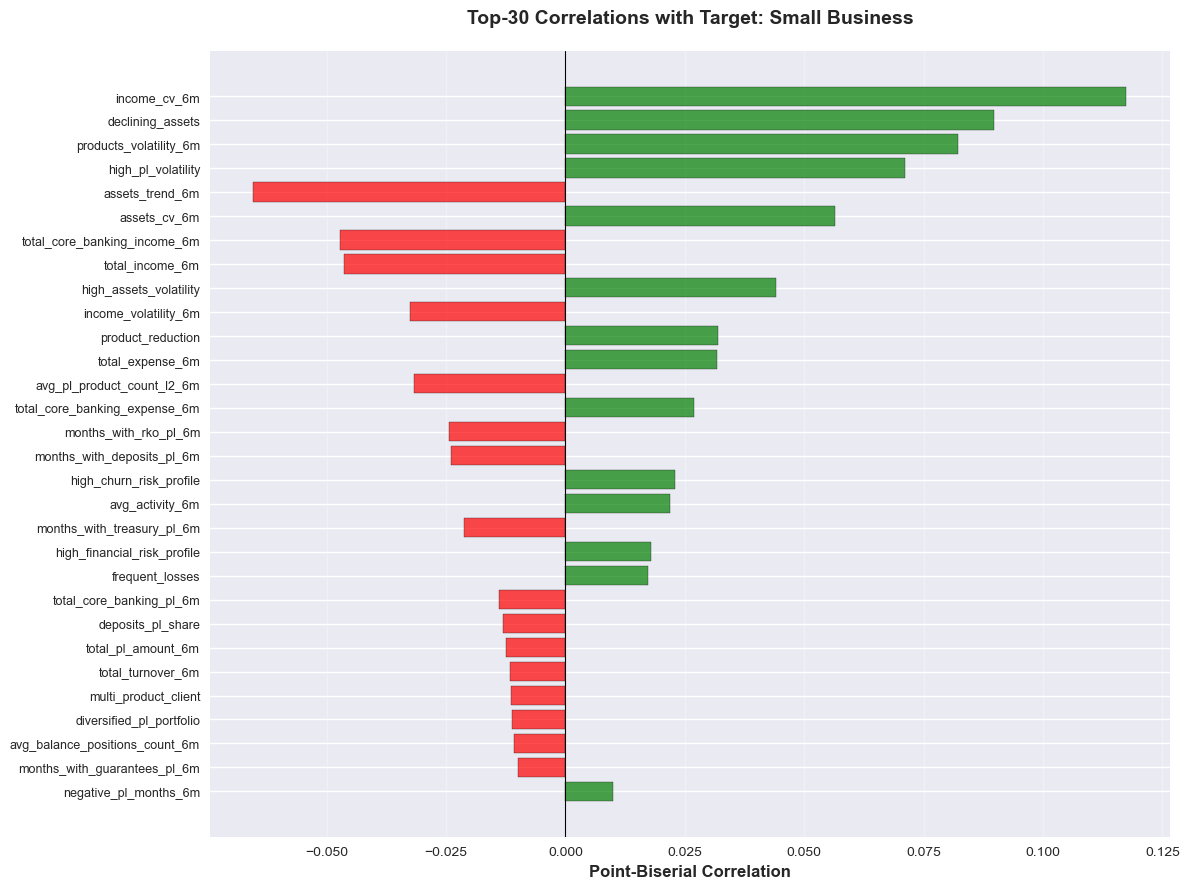

In [17]:
# ====================================================================================
# ВИЗУАЛИЗАЦИЯ: CORRELATION SEGMENT 1
# ====================================================================================

plot_top_correlations(
    corr_seg1,
    config.SEGMENT_1_NAME,
    top_n=config.TOP_N_VISUALIZATION,
    save_path=config.FIGURES_DIR / 'correlation_segment1.png'
)

In [18]:
# ====================================================================================
# CORRELATION ANALYSIS: SEGMENT 2
# ====================================================================================

print("\n" + "="*80)
print(f"CORRELATION ANALYSIS: SEGMENT 2 - {config.SEGMENT_2_NAME.upper()}")
print("="*80)

# Расчет корреляций на train
print(f"\nРасчет Point-Biserial корреляций на train данных...")
start_time = time.time()

corr_seg2 = calculate_pointbiserial_correlations(
    seg2_train, 
    config.TARGET_COLUMN,
    config.CORRELATION_P_VALUE_THRESHOLD
)

elapsed = time.time() - start_time
print(f"\n✓ Расчет завершен за {elapsed:.2f} сек")

# Статистика
print(f"\nОБЩАЯ СТАТИСТИКА:")
print(f"  Всего признаков: {len(corr_seg2)}")
print(f"  Значимых (p<0.05): {corr_seg2['significant'].sum()}")
print(f"  Средняя |корреляция|: {corr_seg2['abs_correlation'].mean():.4f}")
print(f"  Максимальная |корреляция|: {corr_seg2['abs_correlation'].max():.4f}")

# Проверка на data leakage
leakage_features = corr_seg2[corr_seg2['abs_correlation'] > config.DATA_LEAKAGE_THRESHOLD]
if len(leakage_features) > 0:
    print(f"\n ВНИМАНИЕ: Обнаружены признаки с очень высокой корреляцией (>0.9):")
    print(leakage_features[['feature', 'correlation', 'p_value']].head(10))
    print(f"\n Это может указывать на data leakage! Проверьте эти признаки.")
else:
    print(f"\n✓ Признаков с подозрением на data leakage не обнаружено")

# Топ-20 корреляций
print(f"\nТОП-{config.TOP_N_CORRELATIONS} КОРРЕЛЯЦИЙ (по модулю):")
print(corr_seg2.head(config.TOP_N_CORRELATIONS)[['feature', 'correlation', 'p_value', 'significant']].to_string(index=False))


CORRELATION ANALYSIS: SEGMENT 2 - MIDDLE + LARGE BUSINESS

Расчет Point-Biserial корреляций на train данных...
Анализируем 118 числовых признаков...

✓ Расчет завершен за 1.26 сек

ОБЩАЯ СТАТИСТИКА:
  Всего признаков: 61
  Значимых (p<0.05): 36
  Средняя |корреляция|: 0.0178
  Максимальная |корреляция|: 0.0740

✓ Признаков с подозрением на data leakage не обнаружено

ТОП-20 КОРРЕЛЯЦИЙ (по модулю):
                       feature  correlation  p_value  significant
               total_income_6m      -0.0740   0.0000         True
  total_core_banking_income_6m      -0.0666   0.0000         True
          income_volatility_6m      -0.0634   0.0000         True
    avg_pl_product_count_l2_6m      -0.0582   0.0000         True
              total_expense_6m       0.0538   0.0000         True
                  income_cv_6m       0.0502   0.0000         True
avg_balance_positions_count_6m      -0.0466   0.0000         True
              declining_assets       0.0449   0.0000         True
    

In [19]:
# СТАТИСТИКА ABT 


print("\n" + "="*80)
print("СТАТИСТИКА ИТОГОВОЙ ВИТРИНЫ ABT (Section 3.3)")
print("="*80)

data = {
    'Segment 1': {'train': seg1_train, 'val': seg1_val, 'test': seg1_test},
    'Segment 2': {'train': seg2_train, 'val': seg2_val, 'test': seg2_test}
}

segments_info = {
    'Segment 1': config.SEGMENT_1_NAME,
    'Segment 2': config.SEGMENT_2_NAME
}

abt_statistics = {}

for seg_id, seg_data in data.items():
    print(f"\n{seg_id}: {segments_info[seg_id]}")
    print("="*80)
    
    train_df = seg_data['train']
    val_df = seg_data['val'] 
    test_df = seg_data['test']
    
    # Объединяем все splits
    full_df = pd.concat([train_df, val_df, test_df], axis=0)
    
    # Разделяем на числовые и не числовые
    numeric_cols = full_df.select_dtypes(include=[np.number]).columns.tolist()
    non_numeric_cols = full_df.select_dtypes(exclude=[np.number]).columns.tolist()
    
    # Убираем target из предикторов
    if config.TARGET_COLUMN in numeric_cols:
        numeric_cols.remove(config.TARGET_COLUMN)
    
    stats = {
        'Количество наблюдений': len(full_df),
        'Количество событий (churn=1)': int(full_df[config.TARGET_COLUMN].sum()),
        'Уровень целевой переменной (%)': f"{full_df[config.TARGET_COLUMN].mean()*100:.2f}%",
        'Количество числовых предикторов': len(numeric_cols),
        'Количество не числовых предикторов': len(non_numeric_cols),
        'Всего признаков': len(numeric_cols) + len(non_numeric_cols),
        'Train размер': len(train_df),
        'Val размер': len(val_df),
        'Test размер': len(test_df)
    }
    
    abt_statistics[seg_id] = stats
    
    print("\nСтатистика ABT:")
    print("-" * 80)
    for key, value in stats.items():
        print(f"  {key:45s}: {value}")


СТАТИСТИКА ИТОГОВОЙ ВИТРИНЫ ABT (Section 3.3)

Segment 1: Small Business

Статистика ABT:
--------------------------------------------------------------------------------
  Количество наблюдений                        : 3017467
  Количество событий (churn=1)                 : 47155
  Уровень целевой переменной (%)               : 1.56%
  Количество числовых предикторов              : 117
  Количество не числовых предикторов           : 0
  Всего признаков                              : 117
  Train размер                                 : 2024010
  Val размер                                   : 493087
  Test размер                                  : 500370

Segment 2: Middle + Large Business

Статистика ABT:
--------------------------------------------------------------------------------
  Количество наблюдений                        : 210722
  Количество событий (churn=1)                 : 1250
  Уровень целевой переменной (%)               : 0.59%
  Количество числовых предикторов   

In [20]:
# PSI (POPULATION STABILITY INDEX)

def calculate_psi(expected, actual, bins=10):
    # Объединяем для определения границ бинов
    combined = np.concatenate([expected, actual])
    min_val = combined.min()
    max_val = combined.max()
    
    # Создаем бины
    breakpoints = np.linspace(min_val, max_val, bins + 1)
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf
    
    # Распределения по бинам
    expected_counts = np.histogram(expected, bins=breakpoints)[0]
    actual_counts = np.histogram(actual, bins=breakpoints)[0]
    
    # Пропорции (с защитой от деления на 0)
    expected_percents = expected_counts / len(expected)
    actual_percents = actual_counts / len(actual)
    
    # Защита от нулевых значений (добавляем малое число)
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    
    # PSI формула
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi = np.sum(psi_values)
    
    return psi

def interpret_psi(psi_value):
    """Интерпретация значения PSI"""
    if psi_value < 0.1:
        return "Отлично - модель стабильна"
    elif psi_value < 0.2:
        return "Приемлемо - небольшие изменения"
    else:
        return "Требует внимания - значительный drift"

print("\n" + "="*80)
print("PSI (POPULATION STABILITY INDEX) - TRAIN vs TEST")
print("="*80)

psi_results = {}

# Используем словарь data (создан в ABT секции)
for seg_id, seg_data in data.items():
    print(f"\n{seg_id}: {segments_info[seg_id]}")
    print("="*80)
    
    # Получаем данные
    train_df = seg_data['train']
    test_df = seg_data['test']
    
    X_train = train_df.drop(columns=[config.TARGET_COLUMN])
    X_test = test_df.drop(columns=[config.TARGET_COLUMN])
    
    feature_psi = {}
    
    # Рассчитываем PSI для каждого признака
    for col in X_train.columns:
        try:
            psi_val = calculate_psi(X_train[col].values, X_test[col].values)
            feature_psi[col] = psi_val
        except Exception as e:
            feature_psi[col] = np.nan
    
    # Создаем DataFrame
    psi_df = pd.DataFrame({
        'Feature': list(feature_psi.keys()),
        'PSI': list(feature_psi.values())
    }).sort_values('PSI', ascending=False).reset_index(drop=True)
    
    psi_df['Interpretation'] = psi_df['PSI'].apply(interpret_psi)
    
    # Overall PSI (среднее по всем признакам)
    overall_psi = psi_df['PSI'].mean()
    
    print(f"\nОбщий PSI (среднее по всем признакам): {overall_psi:.6f}")
    print(f"Интерпретация: {interpret_psi(overall_psi)}")
    
    print("\n" + "-" * 80)
    print("ТОП-15 признаков с наибольшим PSI:")
    print("-" * 80)
    print(psi_df.head(15).to_string(index=False))
    
    # Статистика по категориям PSI
    excellent = (psi_df['PSI'] < 0.1).sum()
    acceptable = ((psi_df['PSI'] >= 0.1) & (psi_df['PSI'] < 0.2)).sum()
    concerning = (psi_df['PSI'] >= 0.2).sum()
    
    print("\n" + "-" * 80)
    print("Распределение признаков по PSI:")
    print(f"Отличная стабильность (PSI < 0.1):     {excellent} признаков ({excellent/len(psi_df)*100:.1f}%)")
    print(f"Приемлемая стабильность (0.1-0.2):    {acceptable} признаков ({acceptable/len(psi_df)*100:.1f}%)")
    print(f"Требует внимания (PSI >= 0.2):         {concerning} признаков ({concerning/len(psi_df)*100:.1f}%)")
    
    psi_results[seg_id] = {
        'overall_psi': overall_psi,
        'psi_df': psi_df,
        'excellent': excellent,
        'acceptable': acceptable,
        'concerning': concerning
    }
    
    # Сохраняем
    seg_num = seg_id.split()[1]
    psi_file = config.OUTPUT_DIR / f'psi_analysis_seg{seg_num}.csv'
    psi_df.to_csv(psi_file, index=False)
    print(f"\n✓ Сохранено: {psi_file}")


PSI (POPULATION STABILITY INDEX) - TRAIN vs TEST

Segment 1: Small Business

Общий PSI (среднее по всем признакам): 0.004107
Интерпретация: ✅ Отлично - модель стабильна

--------------------------------------------------------------------------------
ТОП-15 признаков с наибольшим PSI:
--------------------------------------------------------------------------------
                       Feature    PSI               Interpretation
         months_with_rko_pl_6m 0.0967 ✅ Отлично - модель стабильна
               income_trend_6m 0.0616 ✅ Отлично - модель стабильна
    avg_pl_product_count_l2_6m 0.0561 ✅ Отлично - модель стабильна
               avg_activity_6m 0.0458 ✅ Отлично - модель стабильна
 total_core_banking_expense_6m 0.0272 ✅ Отлично - модель стабильна
  total_core_banking_income_6m 0.0262 ✅ Отлично - модель стабильна
               assets_trend_6m 0.0215 ✅ Отлично - модель стабильна
               total_income_6m 0.0155 ✅ Отлично - модель стабильна
       months_with_cards_pl_6


КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И МУЛЬТИКОЛЛИНЕАРНОСТЬ

Segment 1: Small Business

1. КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
--------------------------------------------------------------------------------

ТОП-20 признаков с наибольшей корреляцией с target:
income_cv_6m                    0.1175
declining_assets                0.0898
products_volatility_6m          0.0822
high_pl_volatility              0.0712
assets_trend_6m                 0.0653
assets_cv_6m                    0.0564
total_core_banking_income_6m    0.0472
total_income_6m                 0.0464
high_assets_volatility          0.0441
income_volatility_6m            0.0326
product_reduction               0.0319
total_expense_6m                0.0318
avg_pl_product_count_l2_6m      0.0317
total_core_banking_expense_6m   0.0270
months_with_rko_pl_6m           0.0244
months_with_deposits_pl_6m      0.0239
high_churn_risk_profile         0.0229
avg_activity_6m                 0.0218
months_with_treasury_pl_6m      0.0213
high_f

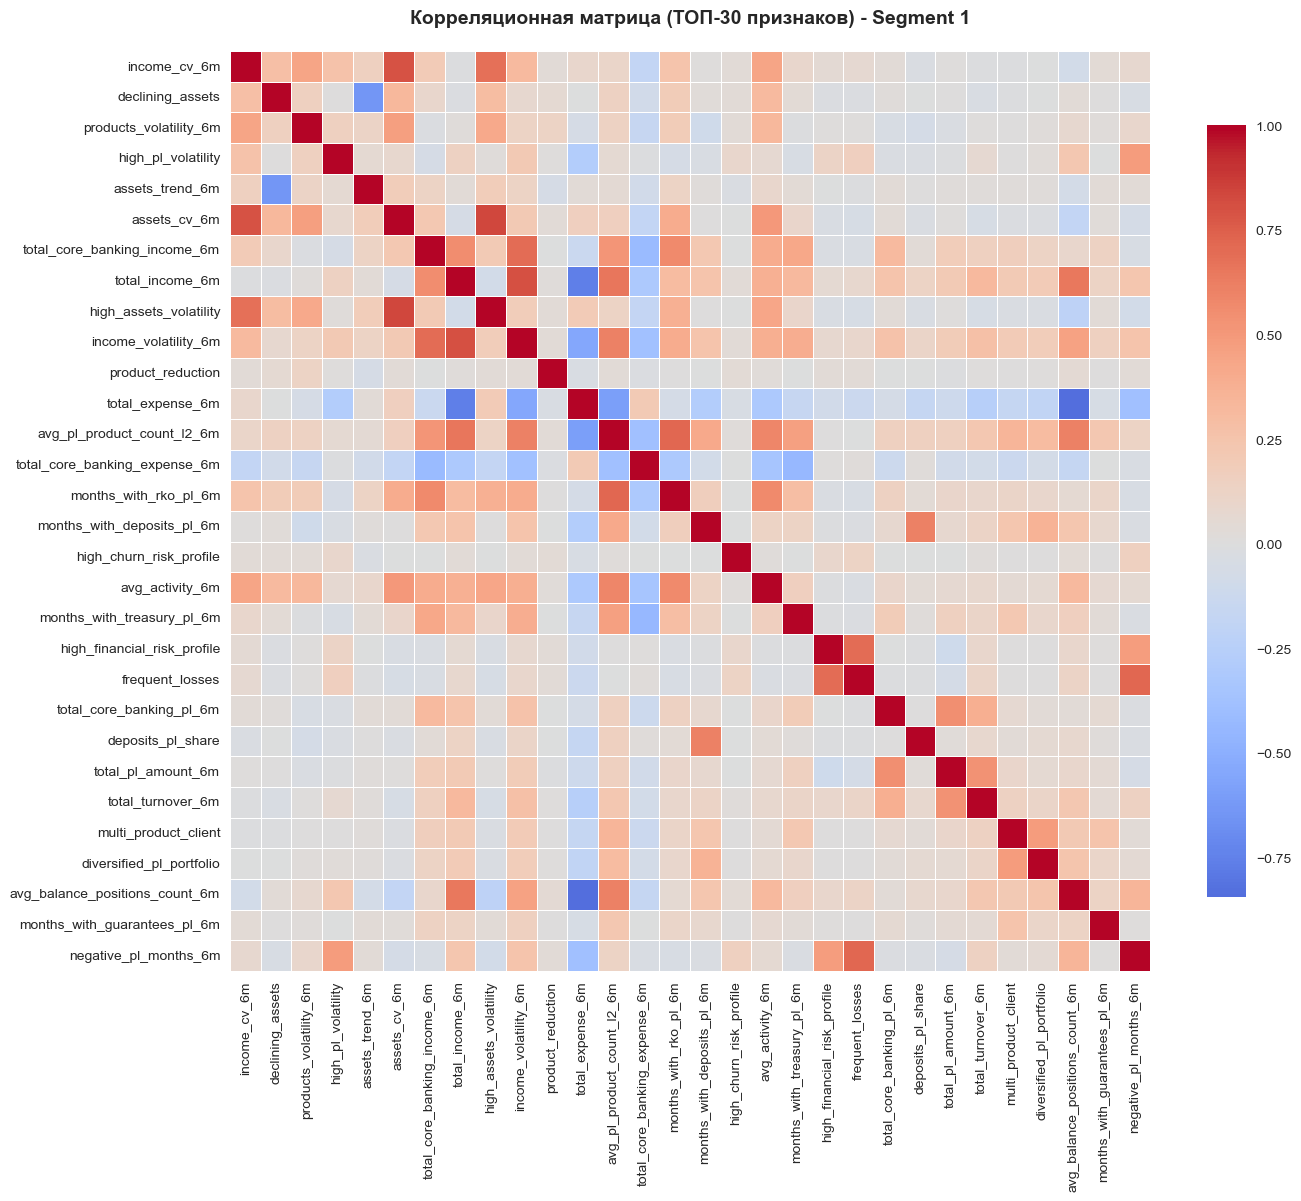


✓ Сохранено: figures\correlation_matrix_seg1.png
✓ Сохранено: output\target_correlation_seg1.csv
✓ Сохранено: output\high_correlation_pairs_seg1.csv

Segment 2: Middle + Large Business

1. КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
--------------------------------------------------------------------------------

ТОП-20 признаков с наибольшей корреляцией с target:
total_income_6m                  0.0740
total_core_banking_income_6m     0.0666
income_volatility_6m             0.0634
avg_pl_product_count_l2_6m       0.0582
total_expense_6m                 0.0538
income_cv_6m                     0.0502
avg_balance_positions_count_6m   0.0466
declining_assets                 0.0449
months_with_deposits_pl_6m       0.0430
assets_trend_6m                  0.0425
assets_cv_6m                     0.0420
roa_6m                           0.0416
months_with_rko_pl_6m            0.0411
total_core_banking_expense_6m    0.0337
months_with_treasury_pl_6m       0.0327
high_assets_volatility           0

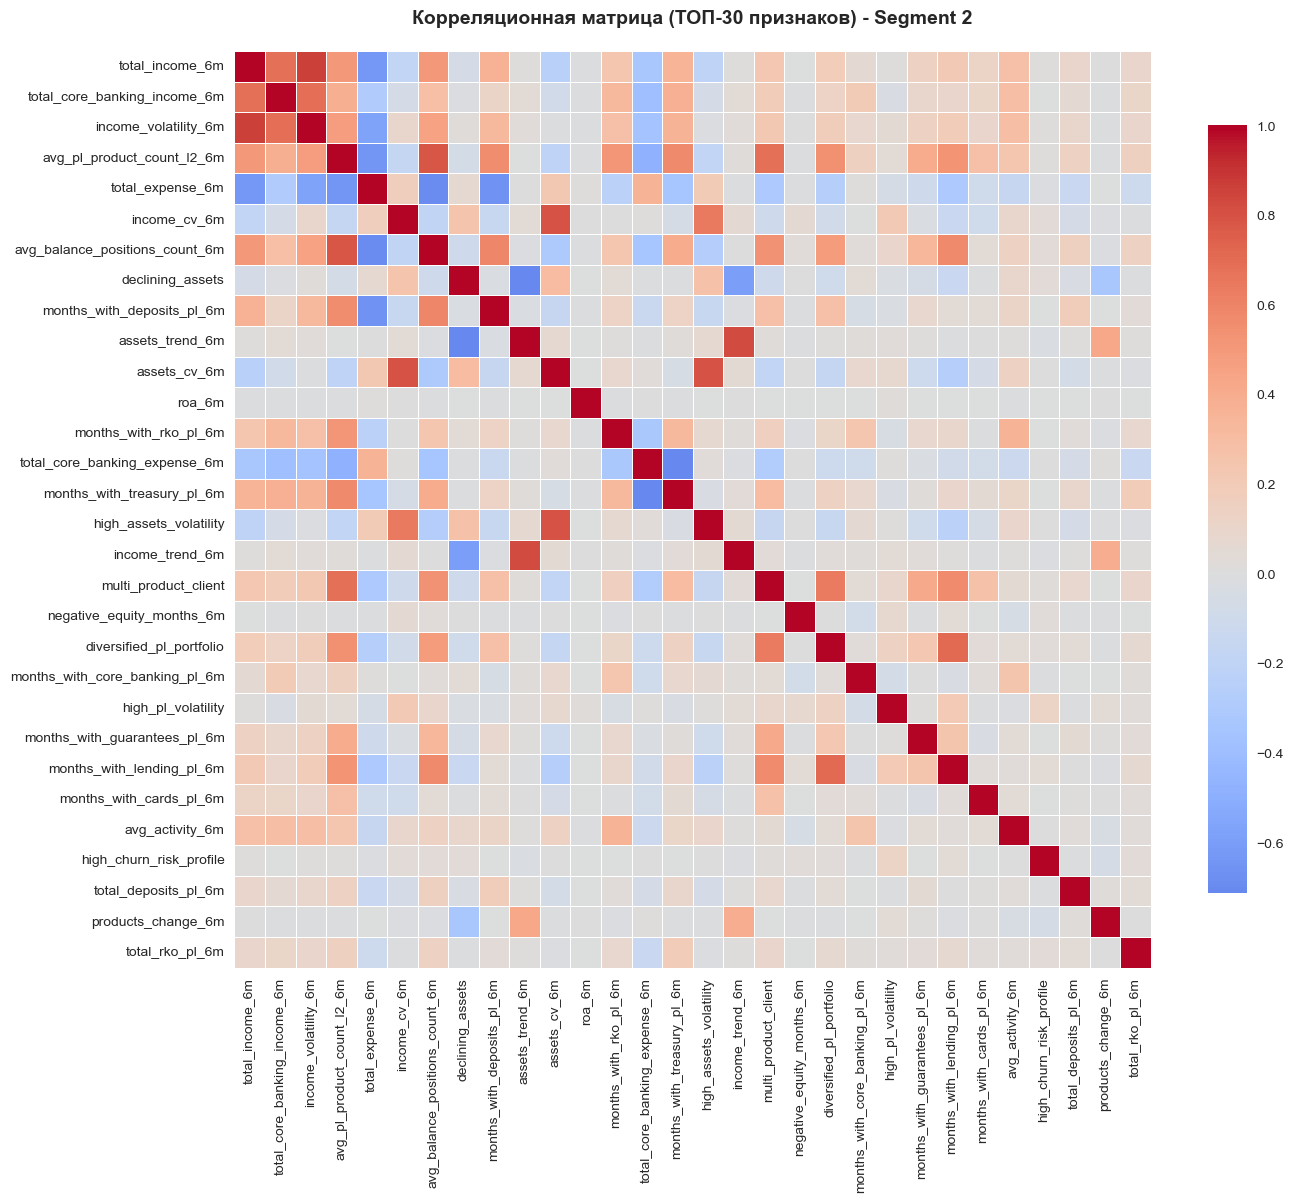


✓ Сохранено: figures\correlation_matrix_seg2.png
✓ Сохранено: output\target_correlation_seg2.csv
✓ Сохранено: output\high_correlation_pairs_seg2.csv

✓ Корреляционный анализ завершен для всех сегментов


In [21]:
# КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И МУЛЬТИКОЛЛИНЕАРНОСТЬ

print("\n" + "="*80)
print("КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И МУЛЬТИКОЛЛИНЕАРНОСТЬ")
print("="*80)

correlation_results = {}

# Используем словарь data (создан в ABT секции)
for seg_id, seg_data in data.items():
    print(f"\n{seg_id}: {segments_info[seg_id]}")
    print("="*80)
    
    # Получаем данные
    train_df = seg_data['train']
    X_train = train_df.drop(columns=[config.TARGET_COLUMN])
    y_train = train_df[config.TARGET_COLUMN]
    
    # Корреляционная матрица
    corr_matrix = X_train.corr()
    
    # 1. Корреляция с целевой переменной
    print("\n1. КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
    print("-" * 80)
    
    # Добавляем target для расчета корреляции
    temp_df = X_train.copy()
    temp_df[config.TARGET_COLUMN] = y_train
    
    target_corr = temp_df.corr()[config.TARGET_COLUMN].drop(config.TARGET_COLUMN).abs().sort_values(ascending=False)
    
    print("\nТОП-20 признаков с наибольшей корреляцией с target:")
    print(target_corr.head(20).to_string())
    
    # 2. Мультиколлинеарность (высокая корреляция между признаками)
    print("\n\n2. МУЛЬТИКОЛЛИНЕАРНОСТЬ (высокая корреляция между признаками)")
    print("-" * 80)
    
    # Находим пары признаков с высокой корреляцией (> 0.8)
    high_corr_threshold = 0.8
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
                high_corr_pairs.append({
                    'Feature_1': corr_matrix.columns[i],
                    'Feature_2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
        print(f"\nНайдено {len(high_corr_df)} пар признаков с |correlation| > {high_corr_threshold}:")
        print("\nТОП-20 пар с наибольшей корреляцией:")
        print(high_corr_df.head(20).to_string(index=False))
    else:
        print(f"\n Пар признаков с |correlation| > {high_corr_threshold} не найдено")
        print("   Мультиколлинеарность не является проблемой")
        high_corr_df = None
    
    # 3. Визуализация корреляционной матрицы (топ-30 признаков по корреляции с target)
    print("\n\n3. ВИЗУАЛИЗАЦИЯ КОРРЕЛЯЦИОННОЙ МАТРИЦЫ")
    print("-" * 80)
    
    # Берем топ-30 признаков
    top_features = target_corr.head(30).index.tolist()
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Матрица корреляции для топ признаков
    top_corr_matrix = X_train[top_features].corr()
    
    sns.heatmap(
        top_corr_matrix,
        cmap='coolwarm',
        center=0,
        annot=False,
        fmt='.2f',
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        ax=ax
    )
    
    ax.set_title(f'Корреляционная матрица (ТОП-30 признаков) - {seg_id}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    seg_num = seg_id.split()[1]
    corr_plot_path = config.FIGURES_DIR / f'correlation_matrix_seg{seg_num}.png'
    plt.savefig(corr_plot_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Сохранено: {corr_plot_path}")
    
    # 4. Сохранение результатов
    correlation_results[seg_id] = {
        'target_correlation': target_corr,
        'high_corr_pairs': high_corr_df,
        'corr_matrix': corr_matrix
    }
    
    # Сохраняем CSV с корреляциями
    target_corr_file = config.OUTPUT_DIR / f'target_correlation_seg{seg_num}.csv'
    target_corr.to_csv(target_corr_file, header=['Correlation_with_Target'])
    print(f"✓ Сохранено: {target_corr_file}")
    
    if high_corr_pairs:
        high_corr_file = config.OUTPUT_DIR / f'high_correlation_pairs_seg{seg_num}.csv'
        high_corr_df.to_csv(high_corr_file, index=False)
        print(f"✓ Сохранено: {high_corr_file}")

print("\n" + "="*80)
print("✓ Корреляционный анализ завершен для всех сегментов")
print("="*80)

In [22]:
# РАЗБИЕНИЕ ВЫБОРКИ - ТАБЛИЦА

print("\nМЕТОД РАЗБИЕНИЯ:")
print("-" * 80)
print("\n✓ TEMPORAL SPLIT (по времени, не random!)")
print("  - Train: 70% первых наблюдений по времени")
print("  - Validation: 15% средних")
print("  - Test (OOT): 15% последних")
print("\n✓ ОБОСНОВАНИЕ:")
print("  - Предотвращение data leakage")
print("  - Test = Out-of-Time validation (реальное будущее)")
print("  - Gap detection: удалены клиенты с пропусками в наблюдениях")

print("\n" + "="*80)
print("ТАБЛИЦА РАЗБИЕНИЯ ВЫБОРКИ")
print("="*80)

split_table_data = []

for seg_id, seg_data in data.items():
    for split_name in ['train', 'val', 'test']:
        df = seg_data[split_name]
        split_table_data.append({
            'Сегмент': seg_id,
            'Роль данных': split_name.upper(),
            'Количество наблюдений': len(df),
            'Количество событий (churn=1)': int(df[config.TARGET_COLUMN].sum()),
            'Churn Rate (%)': f"{df[config.TARGET_COLUMN].mean()*100:.2f}%"
        })

split_table = pd.DataFrame(split_table_data)
print("\n" + split_table.to_string(index=False))


МЕТОД РАЗБИЕНИЯ:
--------------------------------------------------------------------------------

✓ TEMPORAL SPLIT (по времени, не random!)
  - Train: 70% первых наблюдений по времени
  - Validation: 15% средних
  - Test (OOT): 15% последних

✓ ОБОСНОВАНИЕ:
  - Предотвращение data leakage
  - Test = Out-of-Time validation (реальное будущее)
  - Gap detection: удалены клиенты с пропусками в наблюдениях

ТАБЛИЦА РАЗБИЕНИЯ ВЫБОРКИ

  Сегмент Роль данных  Количество наблюдений  Количество событий (churn=1) Churn Rate (%)
Segment 1       TRAIN                2024010                         30472          1.51%
Segment 1         VAL                 493087                          9157          1.86%
Segment 1        TEST                 500370                          7526          1.50%
Segment 2       TRAIN                 129397                           642          0.50%
Segment 2         VAL                  38793                           276          0.71%
Segment 2        TEST    

In [23]:
import pickle
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

In [25]:
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ДЛЯ ОБУЧЕНИЯ

def train_best_model(seg_id, algorithm, X_train, y_train, X_val, y_val, random_seed=42):
    """Обучить лучшую модель для сегмента"""
    
    if algorithm == 'XGBoost':
        model = XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            objective='binary:logistic',
            eval_metric='auc',
            early_stopping_rounds=50,
            random_state=random_seed,
            n_jobs=-1,
            verbosity=0
        )
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
    elif algorithm == 'CatBoost':
        model = CatBoostClassifier(
            iterations=300,
            depth=6,
            learning_rate=0.05,
            loss_function='Logloss',
            eval_metric='AUC',
            early_stopping_rounds=50,
            use_best_model=True,
            random_seed=random_seed,
            task_type='CPU',
            verbose=False,
            allow_writing_files=False
        )
        train_pool = Pool(X_train, y_train)
        val_pool = Pool(X_val, y_val)
        model.fit(train_pool, eval_set=val_pool)
    
    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")
    
    return model

def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """Рассчитать все метрики"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
    
    metrics = {
        'threshold': threshold,
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    metrics['gini'] = 2 * metrics['roc_auc'] - 1
    
    cm = confusion_matrix(y_true, y_pred)
    metrics['tn'], metrics['fp'] = cm[0, 0], cm[0, 1]
    metrics['fn'], metrics['tp'] = cm[1, 0], cm[1, 1]
    
    return metrics

In [26]:
# ОБУЧЕНИЕ ЛУЧШИХ МОДЕЛЕЙ

final_models = {}
final_results = {}

# Лучшие конфигурации (из экспериментов)
best_configs = {
    'Segment 1': {'algorithm': 'XGBoost', 'threshold': 0.12},
    'Segment 2': {'algorithm': 'CatBoost', 'threshold': 0.10}
}

for seg_id, config_model in best_configs.items():
    print(f"\n{seg_id}: {segments_info[seg_id]}")
    print("-" * 80)
    
    # Подготовка данных
    X_train = data[seg_id]['train'].drop(columns=[config.TARGET_COLUMN])
    y_train = data[seg_id]['train'][config.TARGET_COLUMN]
    
    X_val = data[seg_id]['val'].drop(columns=[config.TARGET_COLUMN])
    y_val = data[seg_id]['val'][config.TARGET_COLUMN]
    
    X_test = data[seg_id]['test'].drop(columns=[config.TARGET_COLUMN])
    y_test = data[seg_id]['test'][config.TARGET_COLUMN]
    
    print(f"  Algorithm: {config_model['algorithm']}")
    print(f"  Train shape: {X_train.shape}")
    
    # Обучение
    print(f"  Обучение...")
    import time
    start = time.time()
    
    model = train_best_model(
        seg_id,
        config_model['algorithm'],
        X_train, y_train,
        X_val, y_val,
        random_seed=config.RANDOM_SEED
    )
    
    train_time = time.time() - start
    print(f"  ✓ Обучено за {train_time:.1f} сек")
    
    # Предсказания
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    metrics = calculate_metrics(y_test, y_test_proba, config_model['threshold'])
    
    print(f"\n  МЕТРИКИ (TEST):")
    print(f"    ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"    Gini:      {metrics['gini']:.4f}")
    print(f"    F1:        {metrics['f1']:.4f}")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall:    {metrics['recall']:.4f}")
    
    # Сохранение
    final_models[seg_id] = {
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_test_proba': y_test_proba,
        'algorithm': config_model['algorithm']
    }
    
    final_results[seg_id] = {
        'algorithm': config_model['algorithm'],
        'train_time': train_time,
        **metrics
    }


Segment 1: Small Business
--------------------------------------------------------------------------------
  Algorithm: XGBoost
  Train shape: (2024010, 117)
  Обучение...
  ✓ Обучено за 150.9 сек

  МЕТРИКИ (TEST):
    ROC-AUC:   0.8962
    Gini:      0.7924
    F1:        0.2427
    Precision: 0.2192
    Recall:    0.2719

Segment 2: Middle + Large Business
--------------------------------------------------------------------------------
  Algorithm: CatBoost
  Train shape: (129397, 118)
  Обучение...
  ✓ Обучено за 9.8 сек

  МЕТРИКИ (TEST):
    ROC-AUC:   0.8797
    Gini:      0.7593
    F1:        0.0736
    Precision: 0.0827
    Recall:    0.0663



Segment 1: Small Business

ТОП-20 признаков по важности:
--------------------------------------------------------------------------------
                     Feature  Importance
             avg_activity_6m      0.1974
   months_with_lending_pl_6m      0.1406
             assets_trend_6m      0.0559
          products_change_6m      0.0524
                income_cv_6m      0.0489
        last_month_pl_amount      0.0487
total_core_banking_income_6m      0.0329
          high_pl_volatility      0.0322
            max_pl_amount_6m      0.0285
             total_rko_pl_6m      0.0282
       months_with_rko_pl_6m      0.0252
                      roa_6m      0.0218
       core_banking_pl_share      0.0217
      total_lending_ip_pl_6m      0.0217
          total_pl_amount_6m      0.0200
      products_volatility_6m      0.0172
             total_income_6m      0.0164
            declining_assets      0.0157
                assets_cv_6m      0.0147
  avg_pl_product_count_l2_6m      0.0143


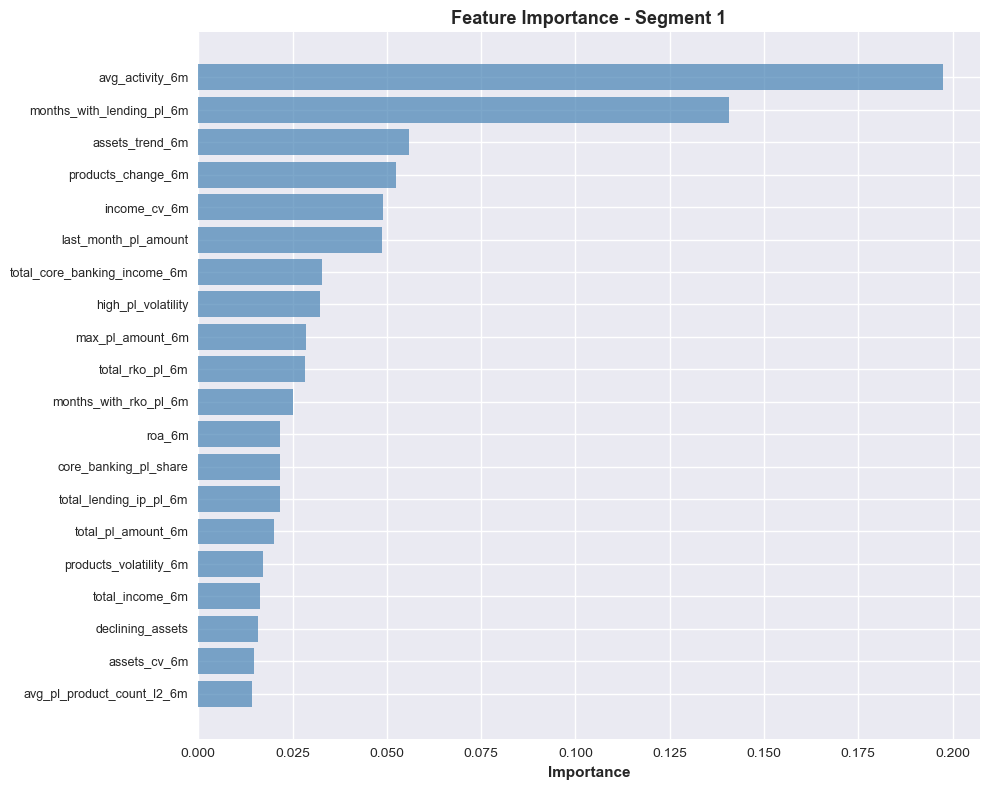


Segment 2: Middle + Large Business

ТОП-20 признаков по важности:
--------------------------------------------------------------------------------
                      Feature  Importance
              assets_trend_6m      8.9415
              income_trend_6m      5.3710
   avg_pl_product_count_l2_6m      4.8877
                 assets_cv_6m      4.8713
         last_month_pl_amount      4.2874
             declining_assets      3.5799
                       roa_6m      3.4533
            total_turnover_6m      3.4119
total_core_banking_expense_6m      3.0078
   months_with_deposits_pl_6m      2.9240
              total_income_6m      2.8482
         total_deposits_pl_6m      2.7621
        first_month_pl_amount      2.7579
                 income_cv_6m      2.7570
                     pl_cv_6m      2.6418
           pl_amount_trend_6m      2.5045
              total_rko_pl_6m      2.5010
        months_with_rko_pl_6m      2.4382
              avg_activity_6m      2.1877
 months_with

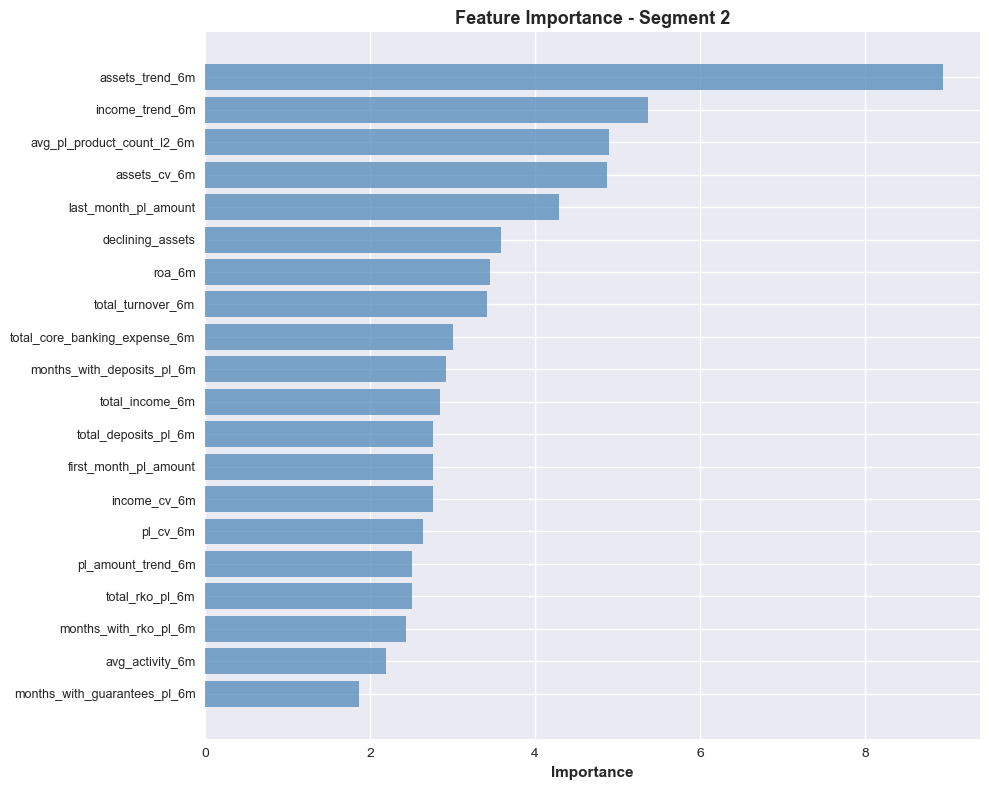

In [27]:
# FEATURE IMPORTANCE

for seg_id, model_data in final_models.items():
    print(f"\n{seg_id}: {segments_info[seg_id]}")
    print("="*80)
    
    model = model_data['model']
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_names = model_data['X_train'].columns
        
        # Create DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False).reset_index(drop=True)
        
        print(f"\nТОП-20 признаков по важности:")
        print("-" * 80)
        print(importance_df.head(20).to_string(index=False))
        
        # Visualization
        top20 = importance_df.head(20)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(range(len(top20)), top20['Importance'], color='steelblue', alpha=0.7)
        ax.set_yticks(range(len(top20)))
        ax.set_yticklabels(top20['Feature'], fontsize=9)
        ax.set_xlabel('Importance', fontsize=11, fontweight='bold')
        ax.set_title(f'Feature Importance - {seg_id}', fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        plt.tight_layout()
        
        seg_num = seg_id.split()[1]
        plt.savefig(config.FIGURES_DIR / f'feature_importance_seg{seg_num}.png', dpi=100)
        plt.show()

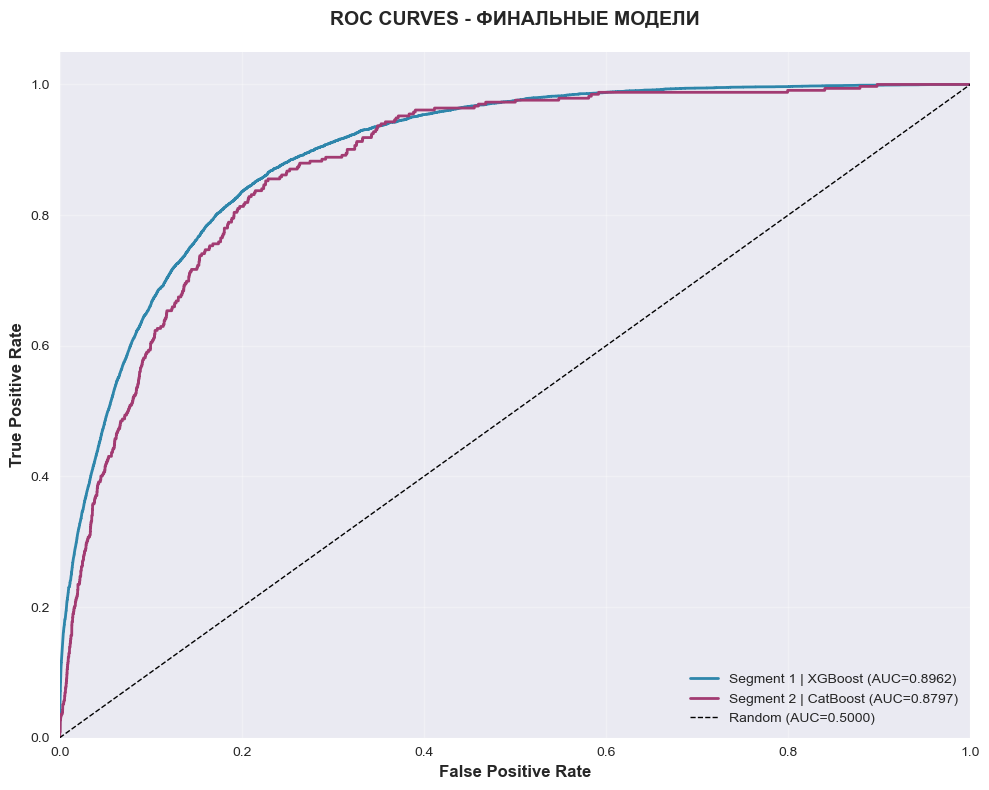

In [28]:
# ====================================================================================
# ROC CURVES - ФИНАЛЬНЫЕ МОДЕЛИ
# ====================================================================================

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#2E86AB', '#A23B72']

for idx, (seg_id, model_data) in enumerate(final_models.items()):
    y_test = model_data['y_test']
    y_pred_proba = model_data['y_test_proba']
    
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = final_results[seg_id]['roc_auc']
    algorithm = model_data['algorithm']
    
    label = f"{seg_id} | {algorithm} (AUC={roc_auc:.4f})"
    ax.plot(fpr, tpr, color=colors[idx], lw=2, label=label)

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC=0.5000)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC CURVES - ФИНАЛЬНЫЕ МОДЕЛИ', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'final_roc_curves.png', dpi=100)
plt.show()

In [29]:
# СОХРАНЕНИЕ ФИНАЛЬНЫХ МОДЕЛЕЙ

print("\n" + "="*80)
print("СОХРАНЕНИЕ ФИНАЛЬНЫХ МОДЕЛЕЙ")
print("="*80)

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

for seg_id, model_data in final_models.items():
    seg_num = seg_id.split()[1]
    algorithm = model_data['algorithm'].lower().replace(' ', '_')
    
    model_file = models_dir / f"final_model_seg{seg_num}_{algorithm}.pkl"
    
    with open(model_file, 'wb') as f:
        pickle.dump(model_data['model'], f)
    
    file_size = model_file.stat().st_size / 1024
    
    print(f"\n✓ {model_file.name}")
    print(f"  Сегмент: {seg_id}")
    print(f"  Алгоритм: {model_data['algorithm']}")
    print(f"  ROC-AUC: {final_results[seg_id]['roc_auc']:.4f}")
    print(f"  Размер: {file_size:.1f} KB")


СОХРАНЕНИЕ ФИНАЛЬНЫХ МОДЕЛЕЙ

✓ final_model_seg1_xgboost.pkl
  Сегмент: Segment 1
  Алгоритм: XGBoost
  ROC-AUC: 0.8962
  Размер: 1193.7 KB

✓ final_model_seg2_catboost.pkl
  Сегмент: Segment 2
  Алгоритм: CatBoost
  ROC-AUC: 0.8797
  Размер: 655.3 KB
